In [1]:
import numpy as np
import matplotlib.pyplot as plt
from temporal_random_walk import TemporalRandomWalk

def generate_bell_curve_temporal_graph(n_nodes=1000, n_edges=1_000_000, seed=42, time_range=1_000_000):
    np.random.seed(seed)

    # Bell-curve over node indices (higher probability for middle nodes)
    node_probs = np.exp(-0.5 * ((np.arange(n_nodes) - n_nodes / 2) / (n_nodes / 6)) ** 2)
    node_probs /= node_probs.sum()

    sources = np.random.choice(n_nodes, size=n_edges, p=node_probs)
    targets = np.random.choice(n_nodes, size=n_edges, p=node_probs)

    # Remove self-loops
    mask = sources != targets
    sources = sources[mask]
    targets = targets[mask]

    # Assign random timestamps in range [0, time_range)
    timestamps = np.random.randint(0, high=time_range, size=len(sources))

    return sources, targets, timestamps

def plot_node_distributions(edge_node_counts, walk_node_counts):
    nodes = np.arange(1000)

    plt.figure(figsize=(14, 6))

    plt.plot(nodes, edge_node_counts, label="Edge Participation Count", linewidth=2, alpha=0.8)
    plt.plot(nodes, walk_node_counts, label="Walk Visit Count", linewidth=2, alpha=0.8)
    plt.xlabel("Node ID")
    plt.ylabel("Frequency")
    plt.title("Node Participation: Edges vs Temporal Walks (Exponential Bias)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("plots/synthetic_uniform_walk_vs_edge_distribution.png")
    plt.show()

def run_bell_curve_walk_test():
    print("Generating graph...")
    sources, targets, timestamps = generate_bell_curve_temporal_graph()

    trw = TemporalRandomWalk(
        is_directed=False,
        use_gpu=False,
        max_time_capacity=-1,
        enable_weight_computation=True
    )
    trw.add_multiple_edges(sources, targets, timestamps)

    print("Sampling walks...")
    walks, _, walk_lengths = trw.get_random_walks_and_times(
        max_walk_len=100,
        walk_bias="ExponentialIndex",
        num_walks_total=1_000_000,
        initial_edge_bias="Uniform",
        walk_direction="Forward_In_Time"
    )

    print(f"Avg walk length: {walk_lengths.mean():.2f}")

    # --- Count nodes in edges
    edge_node_counts = np.zeros(1000)
    for node in np.concatenate([sources, targets]):
        edge_node_counts[node] += 1

    # --- Count nodes in walks
    valid_steps = walks[walks != -1]
    walk_node_counts = np.zeros(1000)
    for node in valid_steps:
        walk_node_counts[node] += 1

    # --- Normalize for shape comparability
    edge_node_counts /= edge_node_counts.max()
    walk_node_counts /= walk_node_counts.max()

    # --- Plot
    plot_node_distributions(edge_node_counts, walk_node_counts)


Generating graph...
Sampling walks...
Avg walk length: 96.30


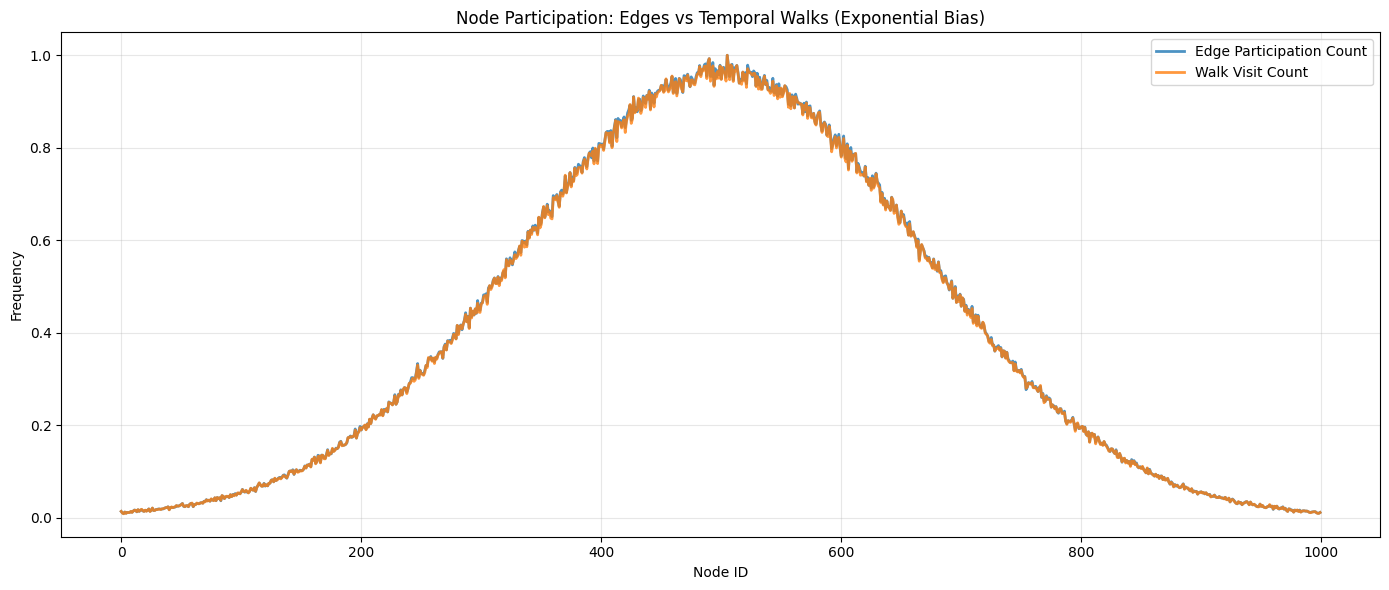

In [2]:
run_bell_curve_walk_test()

Generating graph...
ExponentialIndex → Avg walk length: 96.29
Linear → Avg walk length: 15.27
Uniform → Avg walk length: 9.96


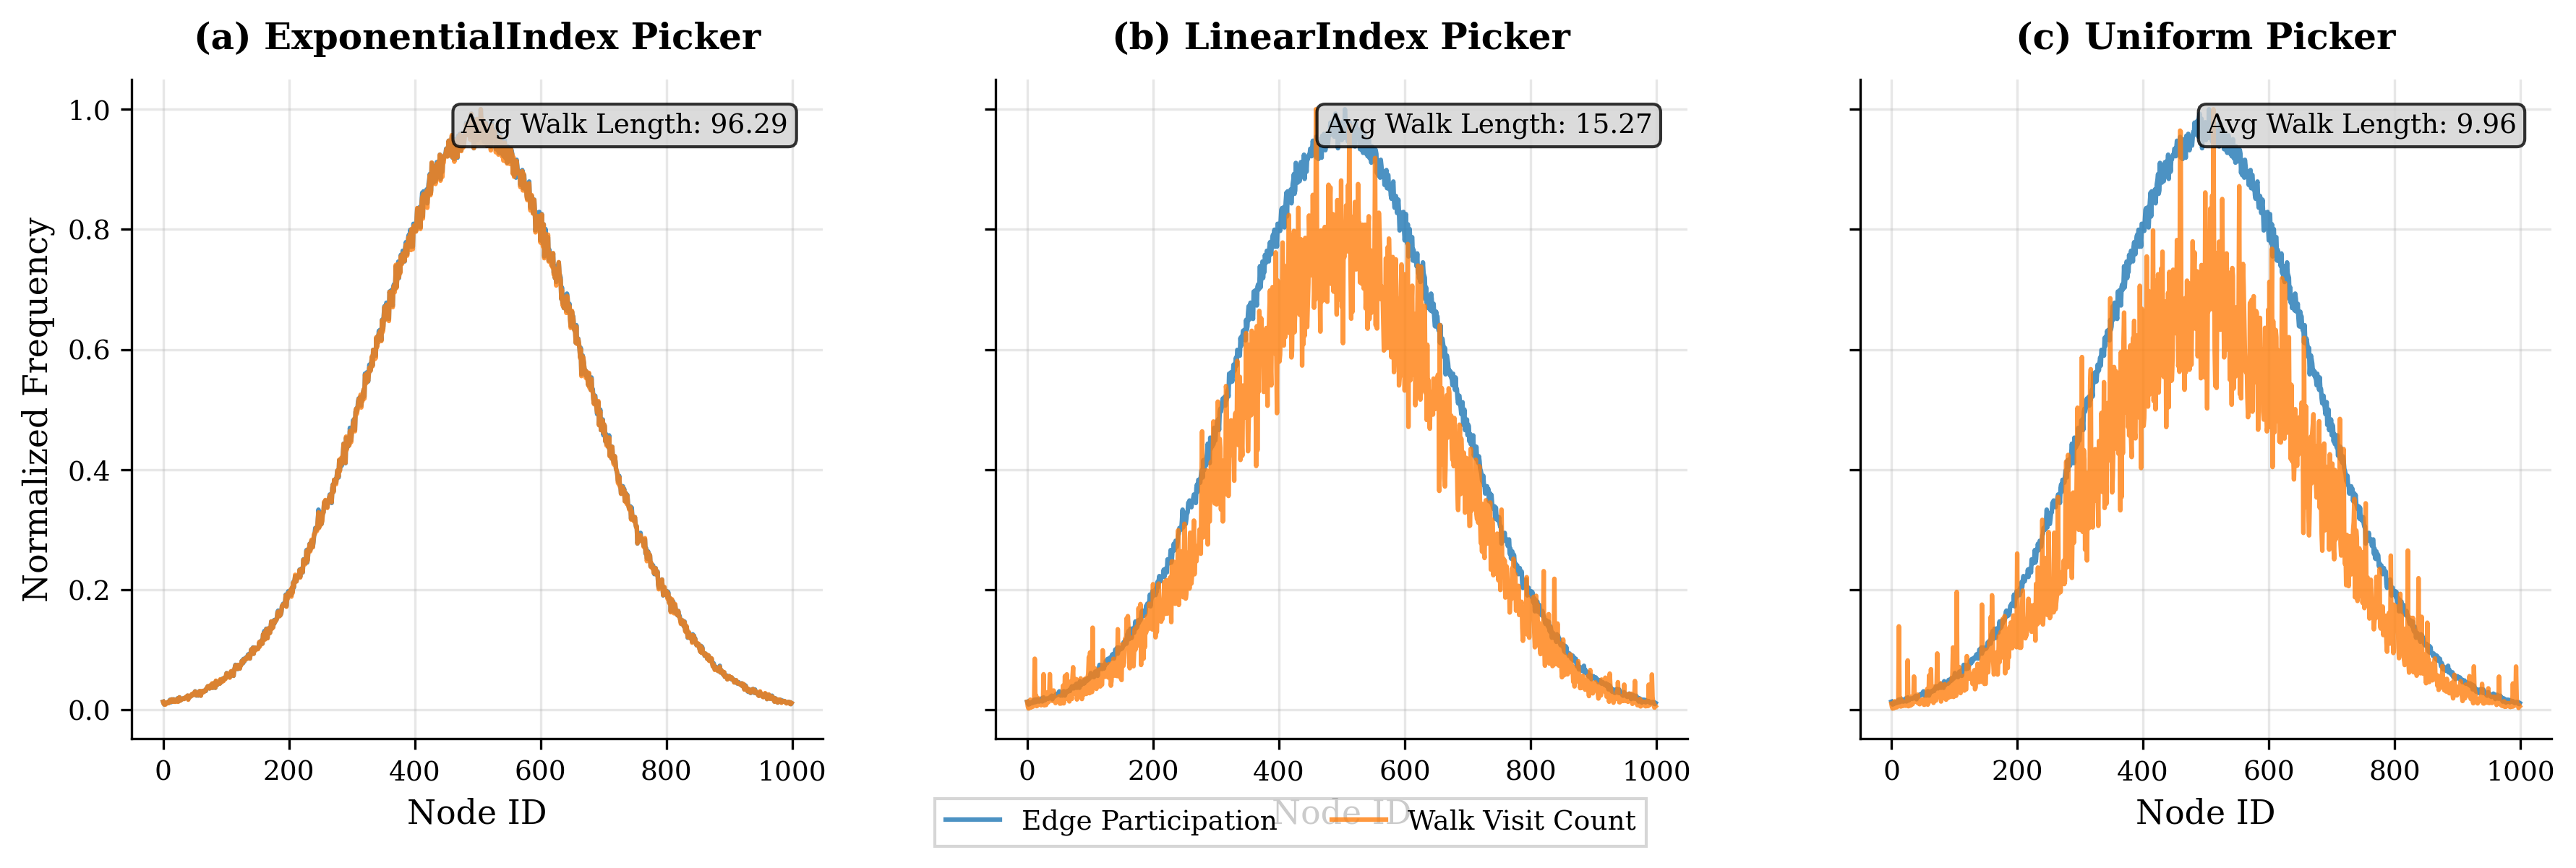

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from temporal_random_walk import TemporalRandomWalk

# Configure fonts and style for academic paper - matching other plots
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'text.usetex': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def run_walk_sampling(edge_picker, sources, targets, timestamps, n_nodes=1000):
    trw = TemporalRandomWalk(
        is_directed=False,
        use_gpu=False,
        max_time_capacity=-1,
        enable_weight_computation=True
    )
    trw.add_multiple_edges(sources, targets, timestamps)

    walks, _, walk_lengths = trw.get_random_walks_and_times(
        max_walk_len=100,
        walk_bias=edge_picker,
        num_walks_total=1_000_000,
        initial_edge_bias="Uniform",
        walk_direction="Forward_In_Time"
    )

    avg_walk_length = walk_lengths.mean()
    print(f"{edge_picker} → Avg walk length: {avg_walk_length:.2f}")

    edge_node_counts = np.zeros(n_nodes)
    for node in np.concatenate([sources, targets]):
        edge_node_counts[node] += 1

    valid_steps = walks[walks != -1]
    walk_node_counts = np.zeros(n_nodes)
    for node in valid_steps:
        walk_node_counts[node] += 1

    edge_node_counts /= edge_node_counts.max()
    walk_node_counts /= walk_node_counts.max()

    return edge_node_counts, walk_node_counts, avg_walk_length

def plot_all_distributions(results, n_nodes=1000):
    pickers = ["ExponentialIndex", "LinearIndex", "Uniform"]

    # Create 1x3 subplot with academic styling
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    # Academic color scheme
    colors = ['#1f77b4', '#ff7f0e']  # Blue, Orange

    for i, (edge_counts, walk_counts, avg_walk_length) in enumerate(results):
        axs[i].plot(np.arange(n_nodes), edge_counts,
                   label="Edge Participation", linewidth=1.5, alpha=0.8, color=colors[0])
        axs[i].plot(np.arange(n_nodes), walk_counts,
                   label="Walk Visit Count", linewidth=1.5, alpha=0.8, color=colors[1])

        axs[i].set_title(f"({chr(97+i)}) {pickers[i]} Picker", fontweight='bold', pad=10)
        axs[i].set_xlabel("Node ID")

        if i == 0:
            axs[i].set_ylabel("Normalized Frequency")

        axs[i].grid(True, alpha=0.3)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].ticklabel_format(style='plain', axis='both')

        # Add average walk length text box
        axs[i].text(0.95, 0.95, f'Avg Walk Length: {avg_walk_length:.2f}',
                   transform=axs[i].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))

    # Add single legend at bottom for all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels,
              loc='lower center',
              bbox_to_anchor=(0.5, -0.02),
              ncol=2,
              frameon=True,
              fancybox=False,
              fontsize=9)

    # Adjust layout - matching other plots
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, top=0.88, bottom=0.12)

    # Save with high quality
    plt.savefig("plots/walk_distribution_comparison.pdf", format='pdf', bbox_inches='tight')
    plt.savefig("plots/walk_distribution_comparison.png", format='png', bbox_inches='tight')
    plt.show()

def run_bell_curve_walk_distribution_experiment():
    print("Generating graph...")
    sources, targets, timestamps = generate_bell_curve_temporal_graph()
    pickers = ["ExponentialIndex", "Linear", "Uniform"]
    results = []

    for picker in pickers:
        edge_counts, walk_counts, avg_walk_length = run_walk_sampling(picker, sources, targets, timestamps)
        results.append((edge_counts, walk_counts, avg_walk_length))

    plot_all_distributions(results)

# Run it
run_bell_curve_walk_distribution_experiment()

In [5]:
import pandas as pd
import os

data_dir = '/Users/ashfaqsalehin/Downloads/TEA-datasets/datasets'

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'out.wikipedia-growth'),
                               sep=r'\s+',
                               skiprows=2,
                               header=None,
                               names=['u', 'i', 'x', 'ts'])

In [7]:
df

,u,i,x,ts
0,1,3,1,982623600
1,4,5,1,982623600
2,1,6,1,982710000
3,1,7,1,982710000
4,1,8,1,982710000
...,...,...,...,...
39953139,1870449,477195,1,1175810400
39953140,889373,415129,1,1175810400
39953141,889373,1870666,1,1175810400
39953142,259241,244935,1,1175810400


In [8]:
df[['u', 'i', 'ts']].to_csv('/Users/ashfaqsalehin/Downloads/TEA-datasets/csv_datasets/growth.csv', index=False)